In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy import stats
import xarray as xr
from cartopy.util import add_cyclic_point
import sys
sys.path.insert(0, '/home/disk/p/aodhan/cf_physical_parameters_correlations/QBOSeasonality2023/')
import toolbox
from matplotlib.colors import LinearSegmentedColormap


# Pull in all timeseries
temp_profs, profiles_cf, profile_all_cf_anoms_zm, profile_transparent_anoms_zm, profile_opaque_anoms_zm, zonal_wind = toolbox.starter()
project_path = '/home/disk/p/aodhan/cf_physical_parameters_correlations'

# also get the vertical temperature gradient
vert_temp_grad_profs = toolbox.vert_temp_gradient(temp_profs)


#### Find the anomalies to all calendars and correct the shape ####
###################################################################
# Temperature
temp_anomalies = toolbox.anomaly_finder(temp_profs)
temp_anomalies = np.nanmean(temp_anomalies, axis=3)
# dT/dZ
vert_tempGrad_anomalies = toolbox.anomaly_finder(vert_temp_grad_profs)
dtdz_anoms_calendar = np.nanmean(vert_tempGrad_anomalies, axis=3)
# TTL Cirrus Clouds
profile_cf_anomalies = toolbox.anomaly_finder(profiles_cf)
ttl_cloud_profile_anoms = profile_cf_anomalies[:,:,:,:,25:-1]
ttl_cloud_profiles_zm_anoms = np.nanmean(ttl_cloud_profile_anoms, axis=3)
# Zonal Wind
zonal_wind_anoms = zonal_wind - np.nanmean(zonal_wind, axis=0)
zonal_wind_anoms = zonal_wind_anoms[:,:,:,:,:75]
zonal_wind_anoms_ts_zm = np.nanmean(zonal_wind_anoms, axis=3)
###################################################################


# Get Cold Point Tropopause altitudes (not important, but helpful for plotting tropopause)
###################################################################
cpt_alts = toolbox.cpt_alt_finder(np.array(temp_profs))
cpt_alts_zm = np.nanmean(cpt_alts, axis=3)
cpt_alts_zm_pres = np.load(project_path + '/tempmaps/calendar_of_cpt_pressures_zm.npy')
cpt_alts_zm = np.nanmean(np.reshape(cpt_alts[:,:,8:16,:], (15,12,8*144)), axis=2)
cpt_pres_zm = np.nanmean(cpt_alts_zm_pres, axis=2)
cpt_alt_smoothed = toolbox.three_month_smoother(cpt_alts_zm)
cpt_pres_smoothed = toolbox.three_month_smoother(cpt_pres_zm)
###################################################################


###### Get the Westerly - Easterly Composites ######
###################################################################
qbo_file = project_path + '/QBOSeasonality2023/data/u50.npy' # The holy QBO-index
###################################################################
cirrus_roladex = toolbox.lead_impact_finder(qbo_file, ttl_cloud_profiles_zm_anoms)
temp_roladex = toolbox.lead_impact_finder(qbo_file, temp_anomalies)
dtdz_roladex = toolbox.lead_impact_finder(qbo_file, dtdz_anoms_calendar)
allcf_roladex = toolbox.lead_impact_finder(qbo_file, profile_all_cf_anoms_zm)
u_roladex = toolbox.lead_impact_finder(qbo_file, zonal_wind_anoms_ts_zm)
transparent_roladex = toolbox.lead_impact_finder(qbo_file, profile_transparent_anoms_zm)
opaque_roladex = toolbox.lead_impact_finder(qbo_file, profile_opaque_anoms_zm)
###################################################################


/home/disk/p/aodhan/cf_physical_parameters_correlations/QBOSeasonality2023/toolbox.py:61: RuntimeWarning: Mean of empty slice
  profile_cf_anoms_zm = np.nanmean(profile_cf_anoms, axis=3)
/home/disk/p/aodhan/cf_physical_parameters_correlations/QBOSeasonality2023/toolbox.py:91: RuntimeWarning: Mean of empty slice
  dt_dz_new = np.nanmean([dt_dz_1, dt_dz_2], axis=0)
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/cf_physical_parameters_correlations/QBOSeasonality2023/toolbox.py:71: RuntimeWarning: Mean of empty slice
  seasonal_average = np.nanmean(data_calendar, axis=0)
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWa

# Figure 1

/home/disk/p/aodhan/.local/lib/python3.7/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/disk/p/aodhan/.local/lib/python3.7/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


Text(-0.3, 11.5, 'Opaque Clouds')

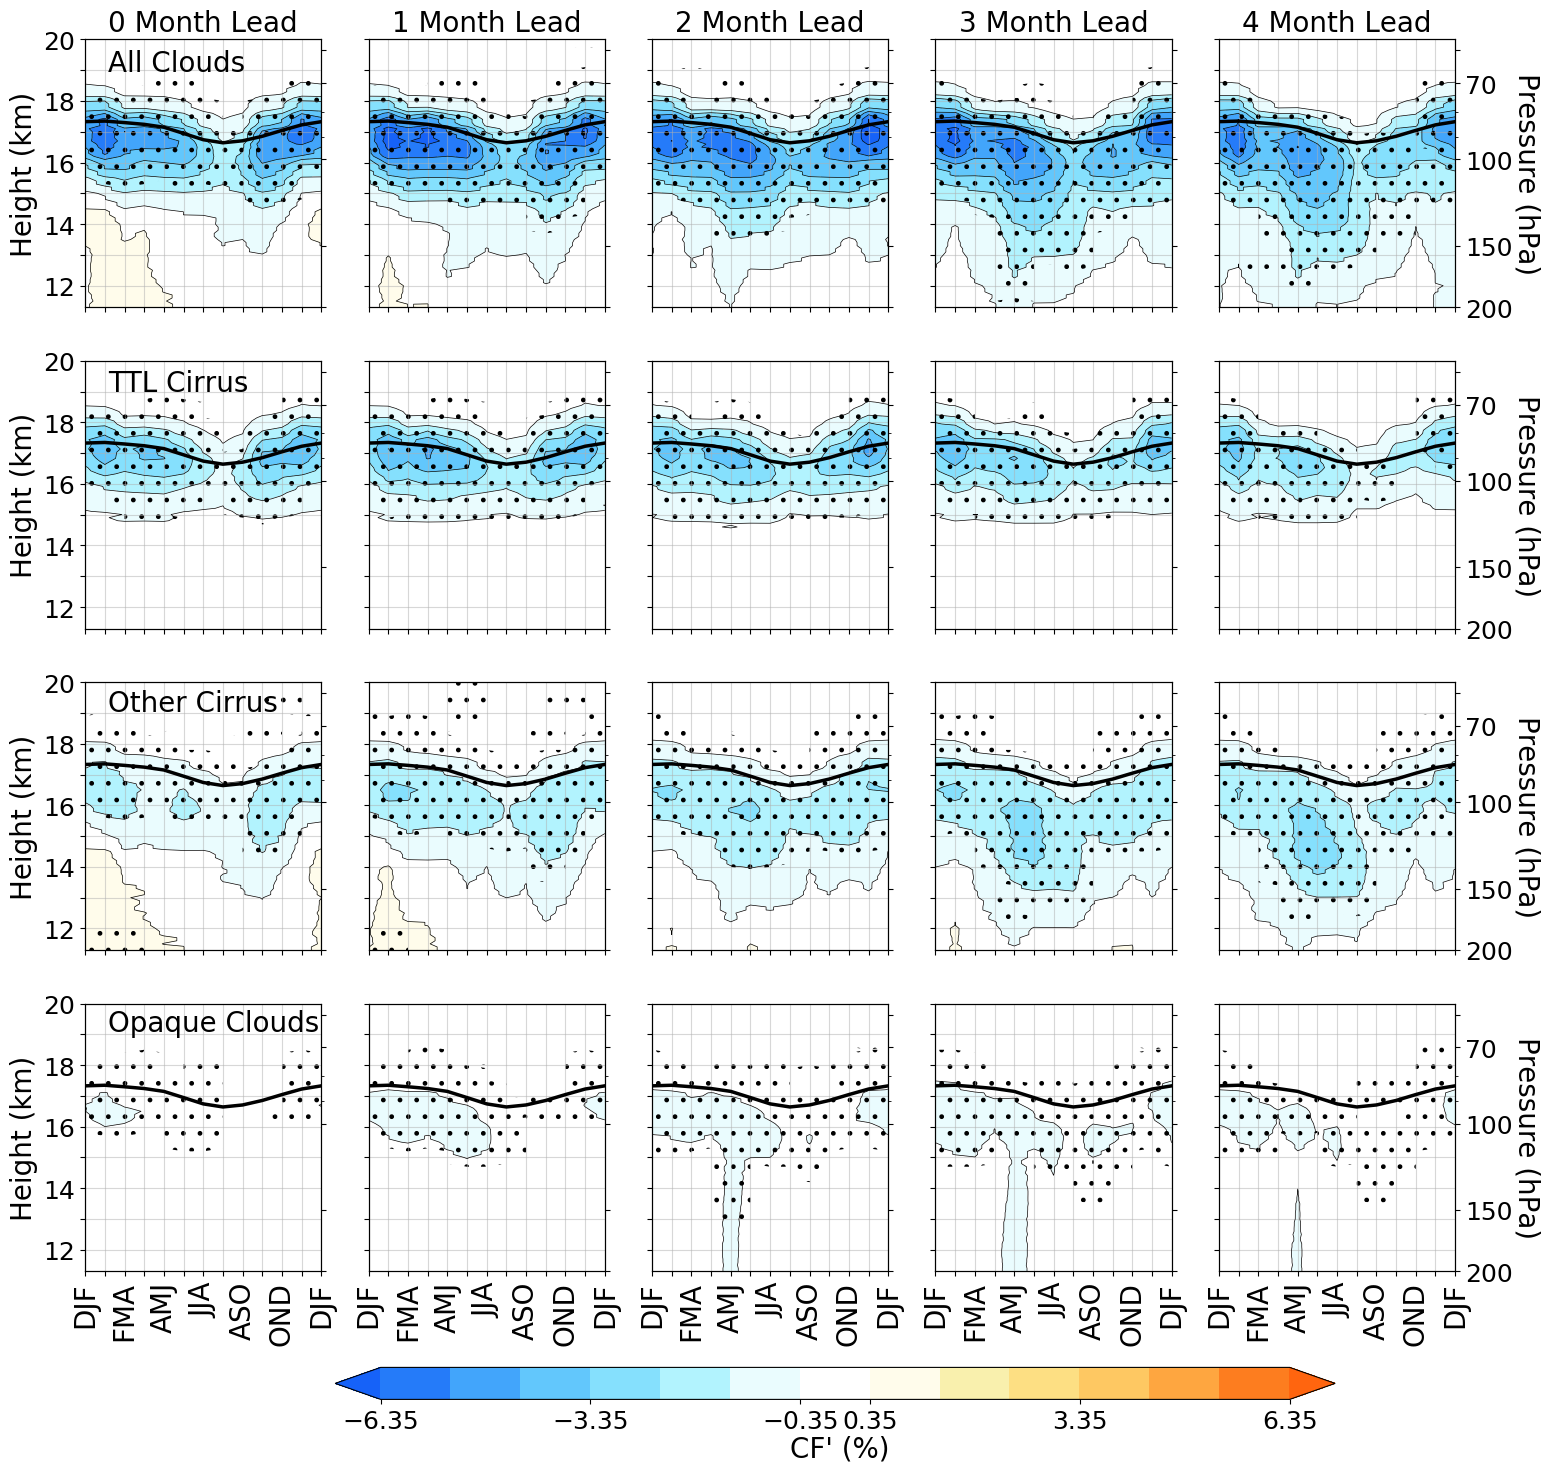

In [2]:
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255

custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

fig, axs = plt.subplots(4,5,figsize=(20,16))
season_names = ['DJF', ' ', 'FMA', ' ', 'AMJ',' ','JJA',' ', 'ASO',' ','OND',' ', 'DJF']

levels_cf = np.array([-6.35,-5.35,-4.35,-3.35,-2.35,-1.35,-.35,.35,1.35,2.35,3.35,4.35,5.35,6.35])

x_ticks = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
for lead in range(5):
    axs[0,lead].set_title(str(lead) + ' Month Lead', fontsize=20)
    for var in range(4):
        if var == 0:
            allcf_cal = allcf_roladex[lead,:,0]
            sig_cal = abs(allcf_cal) - allcf_roladex[lead,:,1]
            sig_cal = sig_cal > 0
            cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
            allcf_heights = np.linspace(0,22,221)
            allcf_press = toolbox.alt2pres(allcf_heights)
            cyclic_cal, mon = add_cyclic_point(allcf_cal.T, coord=x_ticks)
            allcf_im = axs[var,lead].contourf(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, cmap=custom_cmap, extend='both')
            naned_cyclic_cal = cyclic_cal.copy()
            naned_cyclic_cal[:] = np.NaN
            ax2 = axs[var,lead].twinx()
            ax2.set_ylim(ax2.get_ylim()[::-1])
            ax2.set_yscale('log')
            ax2.contourf(mon, allcf_press, naned_cyclic_cal)
            axs[var,lead].contourf(mon, allcf_heights, cyclic_cal_sig, levels=[-1, 0, 1], 
                                   colors='none', hatches=[None,'.'])
            axs[var,lead].contour(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, colors='black', linewidths=0.5, 
                                  linestyles=np.where(levels_cf >= 0, "-", "-"))
            axs[var,lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axs[var,lead].set_xticklabels(labels=[])
            axs[var,lead].set_yticks([11,12,13,14,15,16,17,18,19,20])
            ax2.set_yticks([200, 150, 100, 70, 60])
            if lead == 0:
                axs[var,lead].set_yticklabels(labels=[' ','12',' ','14',' ','16',' ','18',' ','20'], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
                axs[var,lead].set_ylabel("Height (km)", fontsize=20)
            elif lead == 4:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=['200','150','100','70', ' '], fontsize=18)
                ax2.set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
            else:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
            ax2.set_ylim(200,57)
            axs[var,lead].set_ylim(11.3,20)
            axs[var,lead].plot(cpt_alt_smoothed, color='black', linewidth=2.5)
                
        if var == 1:
            ttl_cirrus_cal = cirrus_roladex[lead,:,0]
            sig_cal = abs(ttl_cirrus_cal) - cirrus_roladex[lead,:,1]
            sig_cal = sig_cal > 0
            cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
            cf_heights = np.linspace(14.5,22,75)
            cf_press = toolbox.alt2pres(cf_heights)
            cyclic_cal, mon = add_cyclic_point(ttl_cirrus_cal.T, coord=x_ticks)
            allcf_im = axs[var,lead].contourf(mon, cf_heights, cyclic_cal*100, levels=levels_cf, cmap=custom_cmap, extend='both')
            naned_cyclic_cal = cyclic_cal.copy()
            naned_cyclic_cal[:] = np.NaN
            ax2 = axs[var,lead].twinx()
            ax2.set_ylim(ax2.get_ylim()[::-1])
            ax2.set_yscale('log')
            ax2.contourf(mon, cf_press, naned_cyclic_cal)
            axs[var,lead].contourf(mon, cf_heights, cyclic_cal_sig, levels=[-1, 0, 1], 
                                   colors='none', hatches=[None,'.'])
            axs[var,lead].contour(mon, cf_heights, cyclic_cal*100, levels=levels_cf, colors='black', linewidths=0.5, 
                                  linestyles=np.where(levels_cf >= 0, "-", "-"))
            axs[var,lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axs[var,lead].set_xticklabels(labels=[])
            axs[var,lead].set_yticks([11,12,13,14,15,16,17,18,19,20])
            ax2.set_yticks([200, 150, 100, 70, 60])
            if lead == 0:
                axs[var,lead].set_yticklabels(labels=[' ','12',' ','14',' ','16',' ','18',' ','20'], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
                axs[var,lead].set_ylabel("Height (km)", fontsize=20)
            elif lead == 4:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=['200','150','100','70', ' '], fontsize=18)
                ax2.set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
            else:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
            axs[var,lead].set_ylim(11,20)
            ax2.set_ylim(200,57)
            axs[var,lead].set_ylim(11.3,20)
            axs[var,lead].plot(cpt_alt_smoothed, color='black', linewidth=2.5)
        if var == 2:
            allcf_cal = transparent_roladex[lead,:,0]
            sig_cal = abs(allcf_cal) - transparent_roladex[lead,:,1]
            sig_cal = sig_cal > 0
            cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
            allcf_heights = np.linspace(0,22,221)
            allcf_press = toolbox.alt2pres(allcf_heights)
            cyclic_cal, mon = add_cyclic_point(allcf_cal.T, coord=x_ticks)
            allcf_im = axs[var,lead].contourf(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, cmap=custom_cmap, extend='both')
            naned_cyclic_cal = cyclic_cal.copy()
            naned_cyclic_cal[:] = np.NaN
            ax2 = axs[var,lead].twinx()
            ax2.set_ylim(ax2.get_ylim()[::-1])
            ax2.set_yscale('log')
            ax2.contourf(mon, allcf_press, naned_cyclic_cal)
            axs[var,lead].contourf(mon, allcf_heights, cyclic_cal_sig, levels=[-1, 0, 1], 
                                   colors='none', hatches=[None,'.'])
            axs[var,lead].contour(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, colors='black', linewidths=0.5, 
                                  linestyles=np.where(levels_cf >= 0, "-", "-"))
            axs[var,lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axs[var,lead].set_xticklabels(labels=[])
            axs[var,lead].set_yticks([11,12,13,14,15,16,17,18,19,20])
            ax2.set_yticks([200, 150, 100, 70, 60])
            if lead == 0:
                axs[var,lead].set_yticklabels(labels=[' ','12',' ','14',' ','16',' ','18',' ','20'], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
                axs[var,lead].set_ylabel("Height (km)", fontsize=20)
            elif lead == 4:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=['200','150','100','70', ' '], fontsize=18)
                ax2.set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
            else:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
            axs[var,lead].set_ylim(11,20)
            ax2.set_ylim(200,57)
            axs[var,lead].set_ylim(11.3,20)
            axs[var,lead].plot(cpt_alt_smoothed, color='black', linewidth=2.5)
        if var == 3:
            allcf_cal = opaque_roladex[lead,:,0]
            sig_cal = abs(allcf_cal) - opaque_roladex[lead,:,1]
            sig_cal = sig_cal > 0
            cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
            allcf_heights = np.linspace(0,22,221)
            allcf_press = toolbox.alt2pres(allcf_heights)
            cyclic_cal, mon = add_cyclic_point(allcf_cal.T, coord=x_ticks)
            allcf_im = axs[var,lead].contourf(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, cmap=custom_cmap, extend='both')
            naned_cyclic_cal = cyclic_cal.copy()
            naned_cyclic_cal[:] = np.NaN
            ax2 = axs[var,lead].twinx()
            ax2.set_ylim(ax2.get_ylim()[::-1])
            ax2.set_yscale('log')
            ax2.contourf(mon, allcf_press, naned_cyclic_cal)
            axs[var,lead].contourf(mon, allcf_heights, cyclic_cal_sig, levels=[-1, 0, 1], 
                                   colors='none', hatches=[None,'.'])
            axs[var,lead].contour(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, colors='black', linewidths=0.5, 
                                  linestyles=np.where(levels_cf >= 0, "-", "-"))
            axs[var,lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axs[var,lead].set_xticklabels(labels=[])
            axs[var,lead].set_yticks([11,12,13,14,15,16,17,18,19,20])
            ax2.set_yticks([200, 150, 100, 70, 60])
            if lead == 0:
                axs[var,lead].set_yticklabels(labels=[' ','12',' ','14',' ','16',' ','18',' ','20'], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
                axs[var,lead].set_ylabel("Height (km)", fontsize=20)
            elif lead == 4:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=['200','150','100','70', ' '], fontsize=18)
                ax2.set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
            else:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
            ax2.set_ylim(200,57)
            axs[var,lead].set_ylim(11.3,20)
            axs[var,lead].plot(cpt_alt_smoothed, color='black', linewidth=2.5)

        
for item in range(4): 
    for i in range(5):
        axs[item,i].grid(alpha=0.5)
        axs[3,i].set_xticklabels(labels=season_names, fontsize=20, rotation=90)

fig.subplots_adjust(right=0.81)

#cbar_cf = fig.add_axes([0.865, 0.25, 0.02, 0.5])
#fig.colorbar(allcf_im, cax=cbar_cf, orientation='vertical', ticks=[-6.35,-3.35,-.35,.35,3.35,6.35])
cbar_cf = fig.add_axes([0.25, 0.03, 0.5, 0.02])
fig.colorbar(allcf_im, cax=cbar_cf, orientation='horizontal', ticks=[-6.35,-3.35,-.35,.35,3.35,6.35])
#fig.colorbar(allcf_im, cax=cbar_cf, orientation='horizontal', ticks=[-6.35,-3.35,-.35,.35,3.35,6.35])
cbar_cf.tick_params(labelsize=18)
plt.text(0.45, -1.8, "CF' (%)", fontsize = 20, rotation=0)
plt.text(-0.3, 41.5, "All Clouds", fontsize = 20, rotation=0)
plt.text(-0.3, 31.5, "TTL Cirrus", fontsize = 20, rotation=0)
plt.text(-0.3, 21.5, "Other Cirrus", fontsize = 20, rotation=0)
plt.text(-0.3, 11.5, "Opaque Clouds", fontsize = 20, rotation=0)

#plt.savefig('/home/disk/p/aodhan/cf_physical_parameters_correlations/figures/QBOE_CF_partitioning_4mo_leads_regoutENSO.png', dpi=300)


# Figure 5

Text(2.95, 0.15, "dT'/dZ (K/km)")

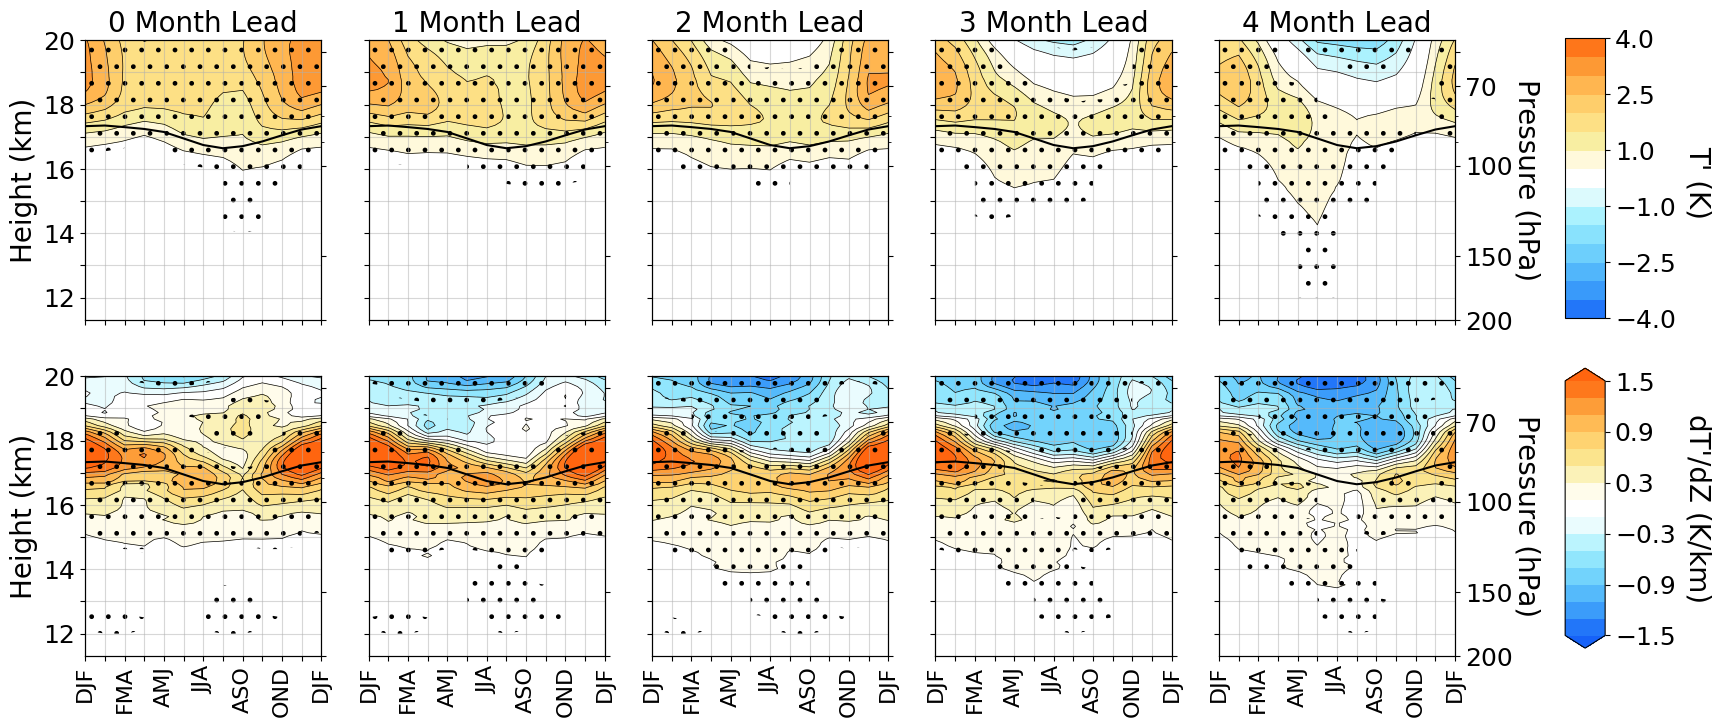

In [3]:
fig, axs = plt.subplots(2,5,figsize=(20,8))
season_names = ['DJF', ' ', 'FMA', ' ', 'AMJ',' ','JJA',' ', 'ASO',' ','OND',' ', 'DJF']

x_ticks = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
for lead in range(5):
    axs[0,lead].set_title(str(lead) + ' Month Lead', fontsize=20)
    for var in range(2):
        if var == 0:
            temp_cal = temp_roladex[lead,:,0]
            sig_cal = abs(temp_cal) - temp_roladex[lead,:,1]
            sig_cal = sig_cal > 0
            cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
            temp_heights = np.linspace(12,22,100)
            temp_press = toolbox.alt2pres(temp_heights)
            levels_temp = np.array([-4,-3.5,-3,-2.5,-2,-1.5,-1,-.5,.5,1,1.5,2,2.5,3,3.5,4])
            cyclic_cal, mon = add_cyclic_point(temp_cal.T, coord=x_ticks)
            temp_im = axs[var,lead].contourf(mon, temp_heights, cyclic_cal, levels=levels_temp, cmap=custom_cmap)
            naned_cyclic_cal = cyclic_cal.copy()
            naned_cyclic_cal[:] = np.NaN
            ax2 = axs[var,lead].twinx()
            ax2.set_ylim(ax2.get_ylim()[::-1])
            ax2.set_yscale('log')
            ax2.contourf(mon, temp_press, naned_cyclic_cal)
            axs[var,lead].contourf(mon, temp_heights, cyclic_cal_sig, levels=[-1, 0, 1], 
                                   colors='none', hatches=[None,'.'])
            axs[var,lead].contour(mon, temp_heights, cyclic_cal, levels=levels_temp, colors='black', linewidths=0.5, 
                                  linestyles=np.where(levels_temp >= 0, "-", "-"))
            axs[var,lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axs[var,lead].set_xticklabels(labels=[])
            axs[var,lead].set_yticks([11,12,13,14,15,16,17,18,19,20])
            ax2.set_yticks([200, 150, 100, 70, 60])
            if lead == 0:
                axs[var,lead].set_yticklabels(labels=[' ','12',' ','14',' ','16',' ','18',' ','20'], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
                axs[var,lead].set_ylabel("Height (km)", fontsize=20)
            elif lead == 4:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=['200','150','100','70', ' '], fontsize=18)
                ax2.set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
            else:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
            axs[var,lead].set_ylim(11,20)
            ax2.set_ylim(200,57)
            axs[var,lead].set_ylim(11.3,20)
            axs[var,lead].plot(cpt_alt_smoothed, color='black')
            
                
        if var == 1:
            dtdz_cal = dtdz_roladex[lead,:,0]
            sig_cal = abs(dtdz_cal) - dtdz_roladex[lead,:,1]
            sig_cal = sig_cal > 0
            cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
            dtdz_heights = np.linspace(12,22,100)
            levels_dtdz = np.array([-1.5, -1.3, -1.1, -0.9, -0.7, -0.5, -0.3, 
                                    -0.1,0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5])
            #levels_dtdz = np.array([-9,-7.5,-6,-4.5,-3, -7.5,1.5,3,4.5,6,7.5,9])/100
            cyclic_cal, mon = add_cyclic_point(dtdz_cal.T, coord=x_ticks)
            dtdz_im = axs[var,lead].contourf(mon, dtdz_heights, cyclic_cal, levels=levels_dtdz, cmap=custom_cmap, extend='both')
            naned_cyclic_cal = cyclic_cal.copy()
            naned_cyclic_cal[:] = np.NaN
            axdtdz = axs[var,lead].twinx()
            axdtdz.set_ylim(axdtdz.get_ylim()[::-1])
            axdtdz.set_yscale('log')
            axdtdz.contourf(mon, temp_press, naned_cyclic_cal)
            axs[var,lead].contour(mon, dtdz_heights, cyclic_cal, levels=levels_dtdz, colors='black', 
                                  linewidths=0.5, 
                                  linestyles=np.where(levels_dtdz >= 0, "-", "-"))
            axs[var,lead].contourf(mon, dtdz_heights, cyclic_cal_sig, levels=[-1, 0, 1], 
                                   colors='none', hatches=[None,'.'])
            axs[var,lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axs[var,lead].set_xticklabels(labels=[])
            axs[var,lead].set_yticks([11,12,13,14,15,16,17,18,19,20])
            axdtdz.set_yticks([200, 150, 100, 70, 60])
            if lead == 0:
                axs[var,lead].set_yticklabels(labels=[' ','12',' ','14',' ','16',' ','18',' ','20'], fontsize=18)
                axdtdz.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
                axs[var,lead].set_ylabel("Height (km)", fontsize=20)
            elif lead == 4:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                axdtdz.set_yticklabels(labels=['200','150','100','70', ' '], fontsize=18)
                axdtdz.set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
            else:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                axdtdz.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
            axs[var,lead].set_ylim(11,20)
            axdtdz.set_ylim(200,57)
            axs[var,lead].set_ylim(11.3,20)
            axs[var,lead].plot(cpt_alt_smoothed, color='black')

        
for item in range(2): 
    for i in range(5):
        axs[item,i].grid(alpha=0.5)
        axs[1,i].set_xticklabels(labels=season_names, fontsize=16, rotation=90)

fig.subplots_adjust(right=0.81)


cbar_temp = fig.add_axes([0.865, 0.5325, 0.02, 0.35])
fig.colorbar(temp_im, cax=cbar_temp, orientation='vertical', ticks=[-4,-2.5,-1,1,2.5,4])
cbar_temp.tick_params(labelsize=18)
plt.text(2.95, 0.375, "T' (K)", fontsize = 20, rotation=270)


cbar_dtdz = fig.add_axes([0.865, 0.12, 0.02, 0.35])
fig.colorbar(dtdz_im, cax=cbar_dtdz, orientation='vertical', 
             ticks=[-1.5, -0.9, -0.3, 0.3, 0.9, 1.5])
cbar_dtdz.tick_params(labelsize=18)
plt.text(2.95, 0.15, "dT'/dZ (K/km)", fontsize = 20, rotation=270)

#plt.savefig('/home/disk/p/aodhan/cf_physical_parameters_correlations/figures/T_dTdZ_4mo_leads_regoutENSO.png', dpi=300)


# Figure 6

Text(2.6, 0.25, "U' (m/s)")

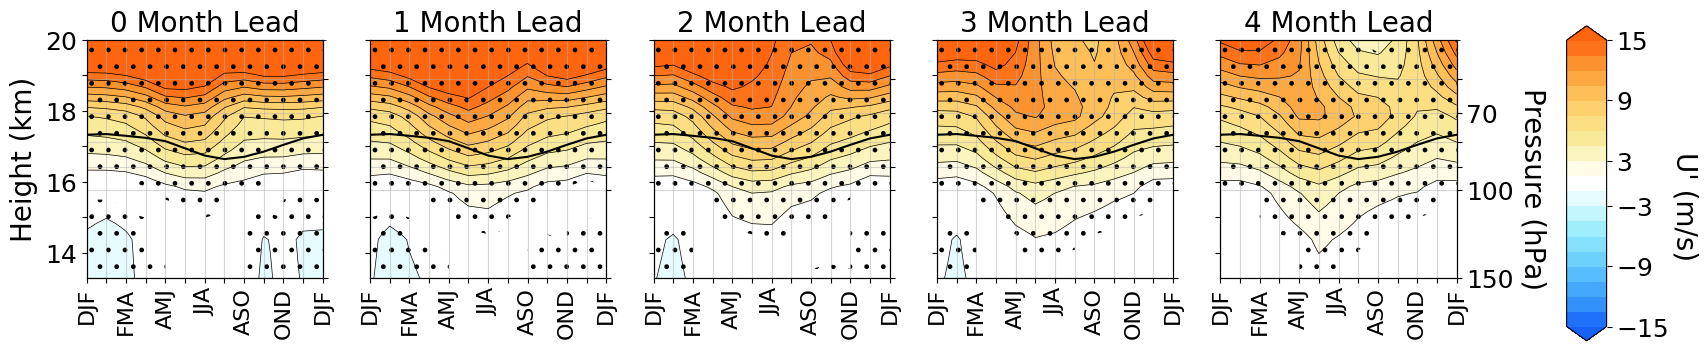

In [4]:
fig, axs = plt.subplots(1,5,figsize=(20,3.5))
season_names = ['DJF', ' ', 'FMA', ' ', 'AMJ',' ','JJA',' ', 'ASO',' ','OND',' ', 'DJF']
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
x_ticks = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
for lead in range(5):
    axs[lead].set_title(str(lead) + ' Month Lead', fontsize=20)
    u_cal = u_roladex[lead,:,0]
    sig_cal = abs(u_cal) - u_roladex[lead,:,1]
    sig_cal = sig_cal > 0
    cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
    u_pressures = np.linspace(50,350,100)[:75]
    alts = np.flip(toolbox.press2alt(u_pressures))
    levels_u = np.array([-15,-13.5,-12,-10.5,-9,-7.5,-6,-4.5,-3,-1.5,1.5,3,4.5,6,7.5,9,10.5,12,13.5,15])
    cyclic_cal, mon = add_cyclic_point(u_cal.T, coord=x_ticks)
    naned_cyclic_cal = cyclic_cal.copy()
    naned_cyclic_cal[:] = np.NaN
    u_im = axs[lead].contourf(mon, u_pressures, cyclic_cal, levels=levels_u, cmap=custom_cmap, extend='both')
    ax2 = axs[lead].twinx()
    ax2.contourf(mon, alts, naned_cyclic_cal)
    axs[lead].contourf(mon, u_pressures, cyclic_cal_sig, levels=[-1, 0, 1], 
                           colors='none', hatches=[None,'.'])
    axs[lead].contour(mon, u_pressures, cyclic_cal, levels=levels_u, colors='black', linewidths=0.5, 
                          linestyles=np.where(levels_u >= 0, "-", "-"))
    ax2.plot(cpt_alt_smoothed, color='black')
    axs[lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
    axs[lead].set_xticklabels(labels=[])
    
    axs[lead].set_ylim(axs[lead].get_ylim()[::-1])
    axs[lead].yaxis.tick_right()
    ax2.yaxis.tick_left()
    axs[lead].set_yscale('log')
    axs[lead].set_yticks([150, 100, 90, 80, 70, 60])
    ax2.set_yticks([14,15,16,17,18,19, 20])

    if lead == 0:
        ax2.set_yticklabels(labels=['14',' ','16',' ','18',' ', '20'], fontsize=18)
        axs[lead].set_yticklabels(labels=[' ',' ',' ',' ', ' ', ' ', ' '], fontsize=18)
        axs[lead].set_ylabel("Height (km)", fontsize=20, labelpad=35)
    elif lead == 4:
        ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ', ' '], fontsize=18)
        #ax2.yaxis.tick_right()
        axs[lead].set_yticklabels(labels=['150','100',' ',' ', '70', ' ', ' '], fontsize=18)
        #axs[i].set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
    else:
        ax2.set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ', ' '], fontsize=18)
        axs[lead].set_yticklabels(labels=[' ',' ',' ',' ', ' ', ' ', ' '], fontsize=18)
        

    #axs[lead].plot(cpt_alt_smoothed, color='black')
    axs[lead].set_xticklabels(labels=season_names, fontsize=16, rotation=90)
    axs[lead].set_ylim(150, 50)
    ax2.set_ylim(13.3,20)
        
for i in range(5):
    axs[i].set_xticklabels(labels=season_names, fontsize=16, rotation=90)
    axs[i].grid(alpha=0.5)

fig.subplots_adjust(right=0.81)
fig.subplots_adjust(bottom=0.2)


cbar_u = fig.add_axes([0.865, 0.02, 0.02, 0.9])
fig.colorbar(u_im, cax=cbar_u, orientation='vertical', ticks=[-15,-9,-3,3,9,15])
cbar_u.tick_params(labelsize=18)
plt.text(-1.2, 0.15, "Pressure (hPa)", fontsize = 20, rotation=270)
plt.text(2.6, 0.25, "U' (m/s)", fontsize = 20, rotation=270)

#plt.savefig('/home/disk/p/aodhan/cf_physical_parameters_correlations/figures/U_4mo_leads_regoutENSO.png', dpi=300)

# Figure 2

In [5]:
enso_index = np.load(project_path + '/QBOSeasonality2023/data/Monthly_ERSSTv5_Niño_3p4_1979_2020.npy')[-180:]
seasons = [[11,0,1], [0,1,2], [1,2,3], [2,3,4], [3,4,5], [4,5,6], [5,6,7],
                [6,7,8], [7,8,9], [8,9,10], [9,10,11], [10,11,0]]
def composites_and_significance_ts(qbo_season, variable_eq_season):
    qbo_season = qbo_season - np.nanmean(qbo_season)
    qbo_season = qbo_season/np.nanstd(qbo_season)
    w_variable_season = variable_eq_season[qbo_season > .5]
    e_variable_season = variable_eq_season[qbo_season < -.5]
    w_season = np.nanmean(w_variable_season, axis=0)
    e_season = np.nanmean(e_variable_season, axis=0)
    w_m_e_season = w_season - e_season

    difference_distribution = []
    w_distribution = []
    e_distribution = []
    for boot_strap_idx in range(1000):
        rand_indices_w = np.random.randint(low=0, high=len(w_variable_season), size=len(w_variable_season))
        random_w_cf_seasons = w_variable_season[rand_indices_w]
        w_distribution.append(np.nanmean(random_w_cf_seasons))
        rand_indices_e = np.random.randint(low=0, high=len(e_variable_season), size=len(e_variable_season))
        random_e_cf_seasons = e_variable_season[rand_indices_e]
        e_distribution.append(np.nanmean(random_e_cf_seasons))
        random_difference = np.nanmean(random_w_cf_seasons, axis=0) - np.nanmean(random_e_cf_seasons, axis=0)
        difference_distribution.append(random_difference)
    two_sigma_difference_significance = np.nanstd(difference_distribution, axis=0)*2
    two_sigma_w_significance = np.nanstd(w_distribution, axis=0)*2
    two_sigma_e_significance = np.nanstd(e_distribution, axis=0)*2

    return(w_m_e_season, two_sigma_difference_significance, 
           w_season, two_sigma_w_significance, 
           e_season, two_sigma_e_significance)

sw_lw = xr.open_dataset('/home/disk/p/aodhan/cf_physical_parameters_correlations/QBOSeasonality2023/data/LongWaveCRE/sw_lw_ceres.nc')
lw_cre_2006_2020 = sw_lw.toa_lw_clr_c_mon.values - sw_lw.toa_lw_all_mon.values
lw_cre_2006_2020 = lw_cre_2006_2020[70:-15]
lw_cre_2006_2020_calendar = np.reshape(lw_cre_2006_2020, (15,12,60,360))
lw_cre_2006_2020_anoms = lw_cre_2006_2020_calendar - np.nanmean(lw_cre_2006_2020_calendar, axis=0)
lw_cre_2006_2020_anoms_equatorial = lw_cre_2006_2020_anoms[:,:,20:40,:]
lw_cre_2006_2020_anoms_equatorial = np.nanmean(np.reshape(lw_cre_2006_2020_anoms_equatorial, (15,12, 20*360)), axis=2)
lw_cre_anoms_cal = np.reshape(lw_cre_2006_2020_anoms_equatorial, (15,12))

lw_roladex = []
for lead in range(5):
    one_lead_lw = []
    if lead == 0:
        qbo_index = np.load(qbo_file)
        qbo = qbo_index - np.nanmean(qbo_index)
        qbo_index = qbo/np.nanstd(qbo)
        qbo_index = qbo_index[-180:]
    else:
        start = -180 - lead
        end = -1*lead
        qbo_index = np.load(qbo_file)
        qbo = qbo_index - np.nanmean(qbo_index)
        qbo_index = qbo/np.nanstd(qbo)
        qbo_index = qbo_index[start:end]
    for idx, season in enumerate(seasons):
        name = season_names[idx]
        lw_season = toolbox.season_finder(lw_cre_anoms_cal, season[0], season[1], season[2])[:]
        qbo_season = toolbox.season_finder(np.reshape(qbo_index, (15,12)), season[0], season[1], season[2])[:]
        ###################### Remove ENSO 3.4 signal ########################################
        enso_season = toolbox.season_finder(np.reshape(enso_index, (15,12)), season[0], season[1], season[2])
        CRE_ENSO_LR = stats.linregress(enso_season, lw_season)
        CRE_ENSO_recreation = CRE_ENSO_LR[1] + CRE_ENSO_LR[0]*enso_season
        lw_season = lw_season - CRE_ENSO_recreation
        ####################################################################################
        one_lead_lw.append(composites_and_significance_ts(qbo_season, lw_season))
    lw_roladex.append(one_lead_lw)
lw_roladex = np.array(lw_roladex)


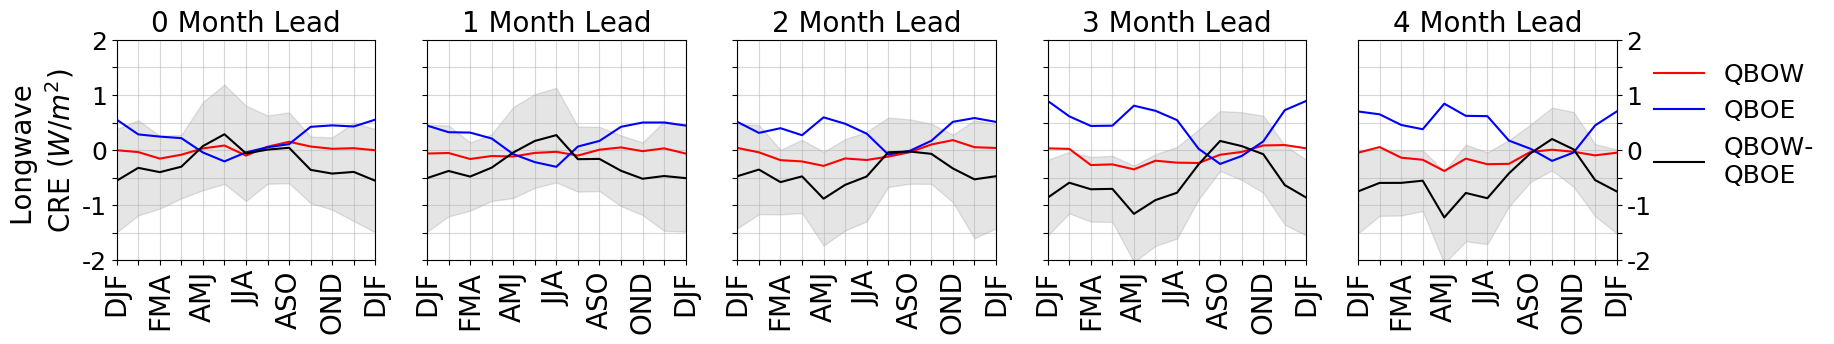

In [6]:
from cartopy.util import add_cyclic_point
months = np.arange(1,13,1)
season_names = ['DJF', ' ', 'FMA', ' ', 'AMJ',' ', 'JJA',' ', 'ASO',' ','OND',' ', 'DJF']
fig, axs = plt.subplots(1,5, figsize=(20,3.5))
for i in range(0, 5):
            cyclic_plot, mon = add_cyclic_point(lw_roladex[i,:,2], coord=months)
            cyclic_plot_sig, mon = add_cyclic_point(lw_roladex[i,:,3], coord=months)
            axs[i].plot(mon, cyclic_plot, color='red', label="QBOW")
            cyclic_plot, mon = add_cyclic_point(lw_roladex[i,:,4], coord=months)
            cyclic_plot_sig, mon = add_cyclic_point(lw_roladex[i,:,5], coord=months)
            axs[i].plot(mon, cyclic_plot, color='blue', label="QBOE")
            cyclic_plot, mon = add_cyclic_point(lw_roladex[i,:,0], coord=months)
            cyclic_plot_sig, mon = add_cyclic_point(lw_roladex[i,:,1], coord=months)
            axs[i].plot(mon, cyclic_plot, color='black', label="QBOW-\nQBOE")
            axs[i].fill_between(mon, cyclic_plot-cyclic_plot_sig, cyclic_plot+cyclic_plot_sig, 
                                    color='black', alpha=0.1)
            axs[i].set_xticks([1,2,3,4,5,6,7,8,9,10,11,12,13])
            axs[i].set_xticklabels([' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ',
                                        ' ', ' ', ' ', ' '])
            axs[i].set_yticks([-2,-1.5,-1,-.5,0,.5,1,1.5,2])
            
            #axs[var,i].set_xticklabels(labels=season_names, fontsize=8, rotation=45)
            axs[i].set_ylim(-2,2)
            axs[i].set_title(str(i) + ' Month Lead', fontsize=20)
            if i == 0:
                axs[i].set_ylabel('Longwave \nCRE ($W/m^{2}$)', fontsize=20)
                axs[i].set_yticklabels(['-2',' ','-1',' ','0',' ','1',' ','2'], fontsize=18)
            elif i == 4:
                axs[i].yaxis.tick_right()
                axs[i].set_yticklabels(['-2',' ','-1',' ','0',' ','1',' ','2'], fontsize=18)
            else:
                axs[i].set_yticklabels([' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                
            axs[i].grid(alpha=0.5)
            axs[i].set_xticklabels(labels=season_names, fontsize=20, rotation=90)
            axs[0].legend(frameon=False, bbox_to_anchor=(6.65, 1), fontsize=18)
            
for i in range(5):
    axs[i].set_xlim(1,13)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(right=.875)

#plt.savefig('/home/disk/p/aodhan/cf_physical_parameters_correlations/figures/LW_CRE_4mo_leads_regoutENSO.png', dpi=300)
    

# Figure 3

In [7]:
def difference_and_significance_map_w(qbo_season, variable_eq_season):
    w_variable_season = variable_eq_season[qbo_season > .5]
    e_variable_season = variable_eq_season[qbo_season < -.5]
    w_m_e_season = np.nanmean(w_variable_season, axis=0) #- np.nanmean(e_variable_season, axis=0)
    w_season = np.nanmean(w_variable_season, axis=0)
    e_season = np.nanmean(e_variable_season, axis=0)
    difference_distribution = []
    w_distribution = []
    e_distribution = []
    for boot_strap_idx in range(1000):
        rand_indices_w = np.random.randint(low=0, high=len(w_variable_season), size=len(w_variable_season))
        random_w_cf_seasons = w_variable_season[rand_indices_w]
        w_distribution.append(np.nanmean(random_w_cf_seasons, axis=0))
        rand_indices_e = np.random.randint(low=0, high=len(e_variable_season), size=len(e_variable_season))
        random_e_cf_seasons = e_variable_season[rand_indices_e]
        e_distribution.append(np.nanmean(random_e_cf_seasons, axis=0))
        random_difference = np.nanmean(random_w_cf_seasons, axis=0) - np.nanmean(random_e_cf_seasons, axis=0)
        difference_distribution.append(random_difference)
    two_sigma_significance = np.nanstd(difference_distribution, axis=0)*2
    two_sigma_w_significance = np.nanstd(w_distribution, axis=0)*2
    two_sigma_e_significance = np.nanstd(e_distribution, axis=0)*2
    return(w_m_e_season, two_sigma_significance, w_season, 
           two_sigma_w_significance, e_season, two_sigma_e_significance)

def difference_and_significance_map_e(qbo_season, variable_eq_season):
    w_variable_season = variable_eq_season[qbo_season > .5]
    e_variable_season = variable_eq_season[qbo_season < -.5]
    w_m_e_season = np.nanmean(e_variable_season, axis=0) #- np.nanmean(e_variable_season, axis=0)
    w_season = np.nanmean(w_variable_season, axis=0)
    e_season = np.nanmean(e_variable_season, axis=0)
    difference_distribution = []
    w_distribution = []
    e_distribution = []
    for boot_strap_idx in range(1000):
        rand_indices_w = np.random.randint(low=0, high=len(w_variable_season), size=len(w_variable_season))
        random_w_cf_seasons = w_variable_season[rand_indices_w]
        w_distribution.append(np.nanmean(random_w_cf_seasons, axis=0))
        rand_indices_e = np.random.randint(low=0, high=len(e_variable_season), size=len(e_variable_season))
        random_e_cf_seasons = e_variable_season[rand_indices_e]
        e_distribution.append(np.nanmean(random_e_cf_seasons, axis=0))
        random_difference = np.nanmean(random_w_cf_seasons, axis=0) - np.nanmean(random_e_cf_seasons, axis=0)
        difference_distribution.append(random_difference)
    two_sigma_significance = np.nanstd(difference_distribution, axis=0)*2
    two_sigma_w_significance = np.nanstd(w_distribution, axis=0)*2
    two_sigma_e_significance = np.nanstd(e_distribution, axis=0)*2
    return(w_m_e_season, two_sigma_significance, w_season, 
           two_sigma_w_significance, e_season, two_sigma_e_significance)

def lead_impact_finder(qbo_file, data_calendar):
    data_roladex = []
    for lead in range(5):
        lead_data = []
        if lead == 0:
            qbo_index = np.load(qbo_file)
            qbo = qbo_index - np.nanmean(qbo_index)
            qbo_index = qbo/np.nanstd(qbo)
            qbo_index = qbo_index[-180:]
        else:
            start = -180 - lead
            end = -1*lead
            qbo_index = np.load(qbo_file)
            qbo = qbo_index - np.nanmean(qbo_index)
            qbo_index = qbo/np.nanstd(qbo)
            qbo_index = qbo_index[start:end]
        for idx, season in enumerate(seasons):
            data_season = toolbox.season_finder_profiles(data_calendar, season[0], season[1], season[2])[:]
            qbo_season = toolbox.season_finder(np.reshape(qbo_index, (15,12)), season[0], season[1], season[2])[:]
            ###################### Remove ENSO 3.4 signal ########################################
            enso_season = toolbox.season_finder(np.reshape(enso_index, (15,12)), season[0], season[1], season[2])
            data_season = data_season - toolbox.regression_ts(enso_season, data_season)
            ####################################################################################
            data_eq_season = toolbox.get_eq_mean(data_season)
            data_W_composite = difference_and_significance_map_w(qbo_season, data_eq_season)
            data_E_composite = difference_and_significance_map_e(qbo_season, data_eq_season)
            lead_data.append([data_W_composite, data_E_composite])
        data_roladex.append(lead_data)    
    data_roladex = np.array(data_roladex)
    return data_roladex

allcf_roladex = lead_impact_finder(qbo_file, profile_all_cf_anoms_zm)


/home/disk/p/aodhan/cf_physical_parameters_correlations/QBOSeasonality2023/toolbox.py:104: RuntimeWarning: Mean of empty slice
  eq_mean_calendar = np.nanmean(calendar[:,8:16,:], axis=1)


/home/disk/p/aodhan/.local/lib/python3.7/site-packages/matplotlib/contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/disk/p/aodhan/.local/lib/python3.7/site-packages/matplotlib/contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


Text(-36.75, 0.37, 'QBOE')

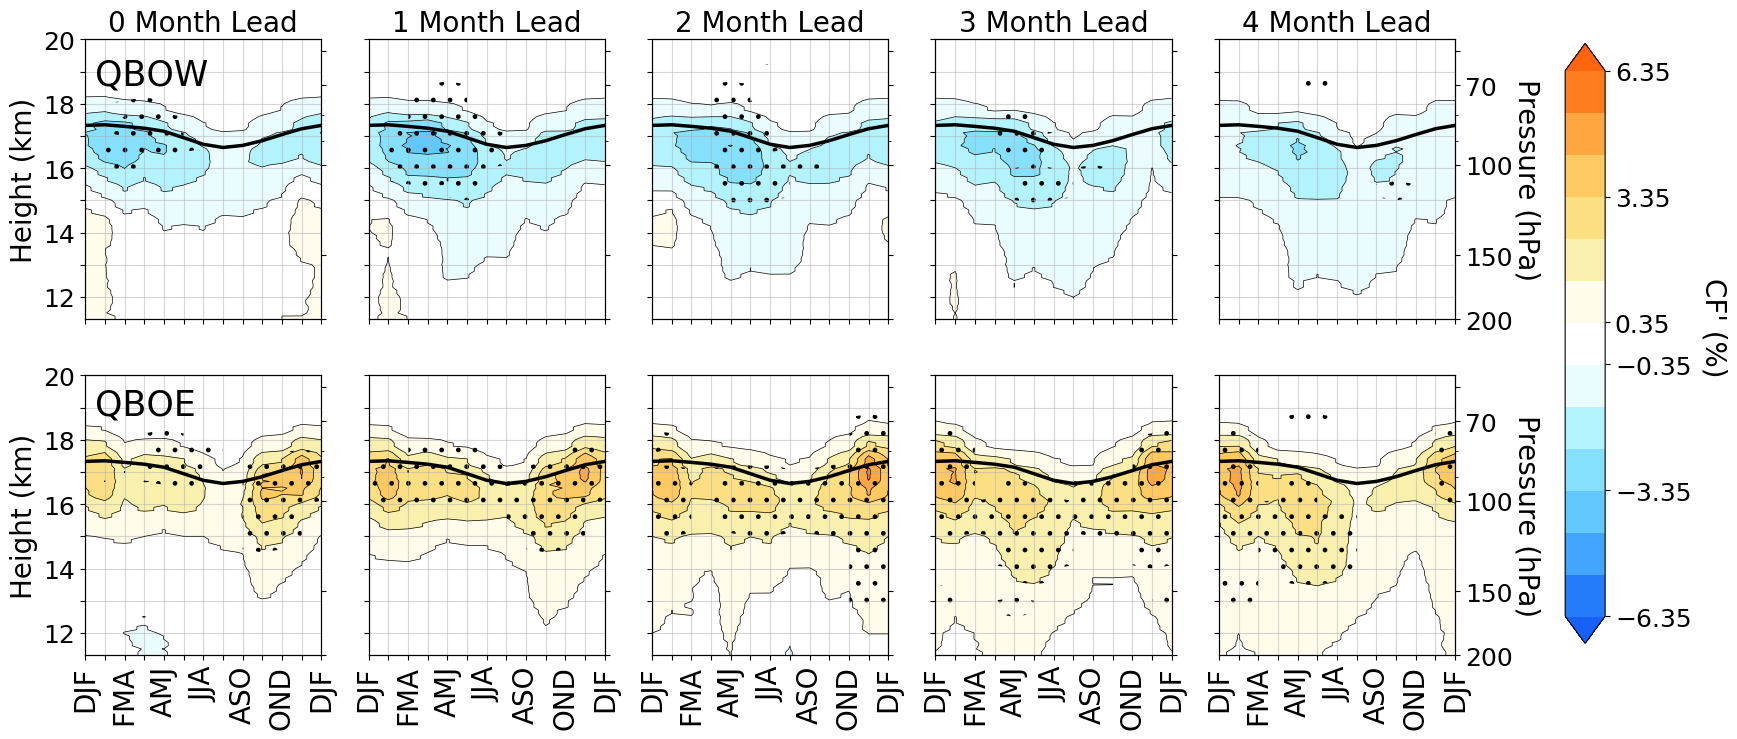

In [8]:
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255

custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

fig, axs = plt.subplots(2,5,figsize=(20,8))
season_names = ['DJF', ' ', 'FMA', ' ', 'AMJ',' ','JJA',' ', 'ASO',' ','OND',' ', 'DJF']

levels_cf = np.array([-6.35,-5.35,-4.35,-3.35,-2.35,-1.35,-.35,.35,1.35,2.35,3.35,4.35,5.35,6.35])

x_ticks = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
for lead in range(5):
    axs[0,lead].set_title(str(lead) + ' Month Lead', fontsize=20)
    for var in range(4):
        if var == 0:
            allcf_roladex_w = allcf_roladex[:,:,0,:,:]
            allcf_cal = allcf_roladex_w[lead,:,0]
            sig_cal = abs(allcf_cal) - allcf_roladex_w[lead,:,1]
            sig_cal = sig_cal > 0#allcf_roladex[lead,:,1]
            cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
            allcf_heights = np.linspace(0,22,221)
            allcf_press = toolbox.alt2pres(allcf_heights)
            cyclic_cal, mon = add_cyclic_point(allcf_cal.T, coord=x_ticks)
            allcf_im = axs[var,lead].contourf(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, cmap=custom_cmap, extend='both')
            naned_cyclic_cal = cyclic_cal.copy()
            naned_cyclic_cal[:] = np.NaN
            ax2 = axs[var,lead].twinx()
            ax2.set_ylim(ax2.get_ylim()[::-1])
            ax2.set_yscale('log')
            ax2.contourf(mon, allcf_press, naned_cyclic_cal)
            axs[var,lead].contourf(mon, allcf_heights, cyclic_cal_sig, levels=[-1, 0, 1], 
                                   colors='none', hatches=[None,'.'])
            axs[var,lead].contour(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, colors='black', linewidths=0.5, 
                                  linestyles=np.where(levels_cf >= 0, "-", "-"))
            axs[var,lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axs[var,lead].set_xticklabels(labels=[])
            axs[var,lead].set_yticks([11,12,13,14,15,16,17,18,19,20])
            ax2.set_yticks([200, 150, 100, 70, 60])
            if lead == 0:
                axs[var,lead].set_yticklabels(labels=[' ','12',' ','14',' ','16',' ','18',' ','20'], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
                axs[var,lead].set_ylabel("Height (km)", fontsize=20)
            elif lead == 4:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=['200','150','100','70', ' '], fontsize=18)
                ax2.set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
            else:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
            ax2.set_ylim(200,57)
            axs[var,lead].set_ylim(11.3,20)
            #axs[var,lead].set_ylim(0,20)
            axs[var,lead].plot(cpt_alt_smoothed, color='black', linewidth=2.5)
                
        if var == 1:
            allcf_roladex_e = allcf_roladex[:,:,1,:,:]
            allcf_cal = allcf_roladex_e[lead,:,0]
            sig_cal = abs(allcf_cal) - allcf_roladex_e[lead,:,1]
            sig_cal = sig_cal > 0#allcf_roladex[lead,:,1]
            cyclic_cal_sig, mon = add_cyclic_point(sig_cal.T, coord=x_ticks)
            allcf_heights = np.linspace(0,22,221)
            allcf_press = toolbox.alt2pres(allcf_heights)
            cyclic_cal, mon = add_cyclic_point(allcf_cal.T, coord=x_ticks)
            allcf_im = axs[var,lead].contourf(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, cmap=custom_cmap, extend='both')
            naned_cyclic_cal = cyclic_cal.copy()
            naned_cyclic_cal[:] = np.NaN
            ax2 = axs[var,lead].twinx()
            ax2.set_ylim(ax2.get_ylim()[::-1])
            ax2.set_yscale('log')
            ax2.contourf(mon, allcf_press, naned_cyclic_cal)
            axs[var,lead].contourf(mon, allcf_heights, cyclic_cal_sig, levels=[-1, 0, 1], 
                                   colors='none', hatches=[None,'.'])
            axs[var,lead].contour(mon, allcf_heights, cyclic_cal*100, levels=levels_cf, colors='black', linewidths=0.5, 
                                  linestyles=np.where(levels_cf >= 0, "-", "-"))
            axs[var,lead].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
            axs[var,lead].set_xticklabels(labels=[])
            axs[var,lead].set_yticks([11,12,13,14,15,16,17,18,19,20])
            ax2.set_yticks([200, 150, 100, 70, 60])
            if lead == 0:
                axs[var,lead].set_yticklabels(labels=[' ','12',' ','14',' ','16',' ','18',' ','20'], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
                axs[var,lead].set_ylabel("Height (km)", fontsize=20)
            elif lead == 4:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=['200','150','100','70', ' '], fontsize=18)
                ax2.set_ylabel("Pressure (hPa)", fontsize=20, rotation=270, labelpad=20)
            else:
                axs[var,lead].set_yticklabels(labels=[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '], fontsize=18)
                ax2.set_yticklabels(labels=[' ',' ',' ',' ', ' '], fontsize=18)
            ax2.set_ylim(200,57)
            axs[var,lead].set_ylim(11.3,20)
            axs[var,lead].plot(cpt_alt_smoothed, color='black', linewidth=2.5)
            
        

        
for item in range(2): 
    for i in range(5):
        axs[item,i].grid(alpha=0.5)
        axs[1,i].set_xticklabels(labels=season_names, fontsize=20, rotation=90)

fig.subplots_adjust(right=0.81)

cbar_cf = fig.add_axes([0.865, 0.125, 0.02, 0.75])
fig.colorbar(allcf_im, cax=cbar_cf, orientation='vertical', ticks=[-6.35,-3.35,-.35,.35,3.35,6.35])
cbar_cf.tick_params(labelsize=18)
plt.text(3.35, 0.45, "CF' (%)", fontsize = 20, rotation=270)
plt.text(-36.75, .975, "QBOW", fontsize = 25, rotation=0)
plt.text(-36.75, .37, "QBOE", fontsize = 25, rotation=0)

#plt.savefig('/home/disk/p/aodhan/cf_physical_parameters_correlations/figures/QBOW_QBOE_composite.png', dpi=300)
